# Single point analysis of least-cost paths

Here we pick a single point, in Tasmania, and find the least-cost path to all other points on the island.
It is then visualised, so we can ensure things are making sense.

Most of the time, we'd want to just get the cost of all paths to a point, using the `get_from_point` function, but here we just look at how the algorithm works for a single point.

In [1]:
import meshio
import numpy as np
from multiprocessing import Pool
import time

from LECMesh import LECMesh

In [2]:
#infile = "australia/data/TAS.vtk"
infile = "earth/data/globe.vtk"

mesh = meshio.read(infile)

In [5]:
max_fuel = 2500  # How much fuel does each path have
starting_point = 66772   # Pick a point from the mesh
near_point = 147       # Pick another point, which is relatively close to the starting_point, just for testing

In [7]:
lm = LECMesh(mesh, max_fuel)

In [9]:
# We need to define a way to calculate cost
def elevation_only(mesh, current, _next):
    # Only take into account elevation changes for costs
    if current == _next:
        return 0
    return int(abs(mesh.point_data['Z'][current] - mesh.point_data['Z'][_next]) + distance(mesh, current, _next)*0.004)

In [12]:
lm.travel_cost_function(starting_point, near_point)  # Test the travel_cost function between two points

25396

In [13]:
lm.dist_func(starting_point, near_point)  # Test the distance function between two points

5452296

In [14]:
# Do the least-cost path calculations, and get back the data
#came_from, cost_so_far = cost_search(mesh, starting_point, travel_cost_function = travel_cost, max_distance = max_distance)
came_from, cost_so_far, dist_so_far = lm.cost_search(starting_point)

## Data structures

### came_from
`came_from` is a dictionary, where the keys are point IDs, and the value is the point ID of the point it came_from.

In [15]:
# Show some of the came_from data structure
count = 0
num_points_to_show = 80
for point, preceeding_point in came_from.items():
    print(str(point) + "\tcame from\t" + str(preceeding_point))
    if count > num_points_to_show:
        break
    count +=1

164608	came from	290506
733	came from	413317
165899	came from	262579
165900	came from	413317
117779	came from	543806
543764	came from	23747
543766	came from	487695
543767	came from	99939
543769	came from	164610
543770	came from	385598
183323	came from	364407
543772	came from	99940
243229	came from	412860
243230	came from	117779
167971	came from	256857
167972	came from	49407
45094	came from	271581
167975	came from	79150
43051	came from	175867
43053	came from	543772
543806	came from	23751
385599	came from	364405
543809	came from	543807
543810	came from	487672
385606	came from	238466
45129	came from	271732
146511	came from	543767
7261	came from	543682
99934	came from	167975
99936	came from	290504
99938	came from	290505
99939	came from	164610
99940	came from	172717
99942	came from	364391
99943	came from	364399
99947	came from	256860
99948	came from	543635
99949	came from	219340
99951	came from	487689
99952	came from	262572
412863	came from	79152
57468	came from	364402
487786	came from	9994

You can see above that point `199` "came_from" `None`, since it was the initial point. 

This also means you can pick a point, e.g., `47`, and follow it back until you reach the starting point, AKA, when the `came_from` value is `None`.

In [16]:
# follow a single chain back to the origin point

point = came_from[list(came_from.keys())[-1]]                        # choose a start point
while point:                      # while point is not None
    print(str(point) + " -> ", end="")
    point = came_from[point]

262573 -> 412850 -> 487726 -> 99951 -> 487689 -> 79152 -> 290507 -> 49408 -> 290506 -> 66772 -> 

### cost_so_far

`cost_so_far` is also a dictionary, where the keys are point IDs, and the value is total cost it has taken to reach that point, from the starting point

In [17]:
# the cost to get from the starting point, 199, to the random point 47:
point = came_from[list(came_from.keys())[-1]]                        # choose a start point
print(cost_so_far[point])

1772


In [18]:
# Show the progressive cost of going from a point to the starting point
point = came_from[list(came_from.keys())[-1]]                        # choose a start point
while point:                      # while point is not None
    print(str(cost_so_far[point]) + " -> ", end="")
    point = came_from[point]

1772 -> 1177 -> 899 -> 760 -> 623 -> 460 -> 345 -> 230 -> 115 -> 0 -> 

## Show a map of all shortest paths

Since all paths have to lead back to the starting point, we can map out each of their paths by finding edge nodes, and then following the `came_from` paths back to the starting point.

In [19]:
# Find all the nodes that are at the edge of the tree
edge_nodes = []

for k in came_from.keys():             # For all the points we've visited,
    if k not in came_from.values():    # Find all the points that haven't been 'came_from'
        edge_nodes.append(k)
        
print(edge_nodes)

[733, 543764, 543766, 543769, 543770, 243230, 167972, 45094, 543809, 385606, 146511, 7261, 99949, 99952, 487786, 543920, 412851, 412858, 412862, 412865, 219341, 66774, 219354, 219358, 271583, 271733, 300796, 487677, 300798, 487681, 487690, 487691, 587024, 487700, 487702, 487703, 487704, 325422, 487718, 487724, 325423, 487732, 487733, 300797, 209737, 209738, 209739, 209740, 487775, 364393, 364394, 364403, 364406, 271736, 271738, 543621, 228742, 543623, 543627, 117741, 543638, 262570, 117700, 12232, 117727, 72166, 117739, 300799]


In [20]:
# For each edge node, follow the path back to the starting point, and keep track of the points and costs along the way
paths = []
costs = []
for p in edge_nodes:
    point = p
    cost = 0
    new_points = []
    new_costs = []
    while point:
        new_points.append(mesh.points[point])  # note, the points are being pulled from the VTK, so we get all their info
        new_costs.append(cost_so_far[point])
        point = came_from[point]

    new_points = np.array(new_points)
    new_costs  = np.array(new_costs)
    paths.append(new_points)
    costs.append(new_costs)

In [21]:
# Find the highest cost path
max_cost = max([max(c) for c in costs])
print(max_cost)

2475


In [22]:
total_dist = 0
for k in came_from.keys():             # For all the points we've visited,
    if k not in came_from.values():    # Find all the points that haven't been 'came_from'
        total_dist += dist_so_far[k]
print(total_dist)

16505389


<IPython.core.display.Javascript object>


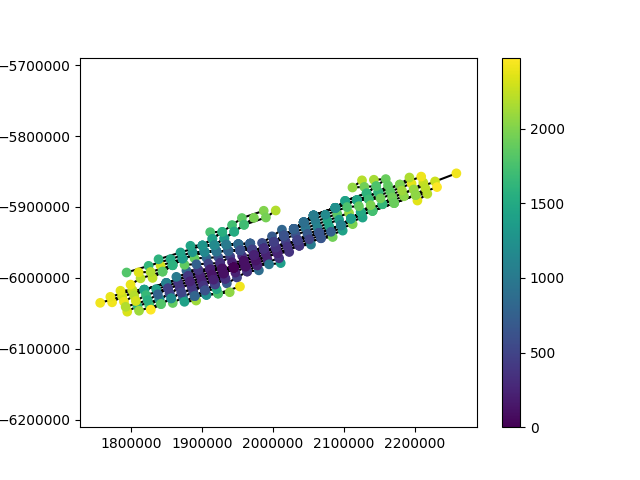

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [23]:
# Visualise all the paths back to the starting point, with colours showing the cost along the way

%matplotlib notebook
import matplotlib.pyplot as plt

norm = plt.Normalize(0, max_cost)
for p, c in zip(paths, costs):    
    plt.plot(p[:,0], p[:,1], c='k', zorder=0)
    plt.scatter(p[:,0], p[:,1], c=c, norm=norm, zorder=1)
    
plt.colorbar()
plt.axes().set_aspect('equal', 'datalim')

In [ ]:
# Visualise all the paths back to the starting point, with colours showing the cost along the way

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

norm = plt.Normalize(0, max_cost)
for p, c in zip(paths, costs):    
    ax.plot(p[:,0], p[:,1], p[:,2], c='k', zorder=0)
    ax.scatter(p[:,0], p[:,1], p[:,2], c=c, norm=norm, zorder=1)
    
#plt.colorbar()
#plt.axes().set_aspect('equal', 'datalim')